In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
import sys

def parse_vmstat_file(filename):
    """
    Parse vmstat log file and return a pandas DataFrame
    """
    with open(filename, 'r') as file:
        data_string = file.read()
    
    # Split the input string into lines
    lines = data_string.strip().split('\n')
    
    # Initialize lists to store data
    headers = []
    data_rows = []
    
    # Parse each line
    for i, line in enumerate(lines):
        # Skip empty lines
        if not line.strip():
            continue
            
        # Check if this is a header line
        if 'procs' in line:
            continue  # Skip the category headers
        elif 'r  b' in line:  # This is the column names line
            # Clean up and split the column names
            headers = re.sub(r'\s+', ' ', line.strip()).split(' ')
        else:
            # This is a data line - split by whitespace
            values = re.sub(r'\s+', ' ', line.strip()).split(' ')
            if len(values) >= 17:  # Ensure we have the expected number of values
                data_rows.append(values)
    
    # Create a DataFrame
    df = pd.DataFrame(data_rows, columns=headers)
    
    # Convert numeric columns to appropriate types
    numeric_columns = ['r', 'b', 'swpd', 'free', 'buff', 'cache', 
                       'si', 'so', 'bi', 'bo', 'in', 'cs',
                       'us', 'sy', 'id', 'wa', 'st', 'gu']
                       
    for col in numeric_columns:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')
    
    # Add a timestamp column (seconds since start)
    df['time'] = range(len(df))
    
    return df

In [4]:
df = parse_vmstat_file("vmstat_log_step_test.txt")
df

,r,b,swpd,free,buff,cache,si,so,bi,bo,in,cs,us,sy,id,wa,st,gu,time
0,0,0,0,3583532,17920,196336,0,0,520,64,170,0,0,1,99,0,0,0,0
1,0,0,0,3583532,17920,196336,0,0,0,0,34,36,0,0,100,0,0,0,1
2,0,0,0,3584168,17920,196344,0,0,0,0,35,53,0,0,100,0,0,0,2
3,0,0,0,3584168,17920,196344,0,0,0,0,32,51,0,0,100,0,0,0,3
4,0,0,0,3583916,17920,196344,0,0,0,0,30,46,0,0,100,0,0,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,0,0,0,3607148,18032,196412,0,0,0,0,5113,543,0,9,91,0,0,0,75
76,0,0,0,3607060,18032,196412,0,0,0,0,5647,560,0,10,90,0,0,0,76
77,0,0,0,3607144,18032,196412,0,0,0,0,4967,545,0,8,92,0,0,0,77
78,0,0,0,3607120,18040,196404,0,0,0,16,4908,580,0,9,88,2,0,0,78


In [5]:
def visualize_cpu_utilization(df, max_threads, output_prefix=None):
    """
    Create a visualization of CPU utilization from vmstat data
    
    Parameters:
    df: DataFrame containing vmstat data
    max_threads: Number of threads in the test
    output_prefix: Prefix for output files (if None, display plots instead)
    """
    # Calculate thread start times based on the test script logic
    # First thread starts after 5 seconds, then each thread launches 10 seconds apart
    thread_start_times = [5]  # First thread starts after 5 seconds
    for i in range(1, max_threads):
        thread_start_times.append(thread_start_times[0] + i * 10)
    
    # Plot CPU utilization over time
    plt.figure(figsize=(14, 8))
    
    # Plot CPU utilization (100 - idle percentage)
    cpu_utilization = 100 - df['id']
    plt.plot(df['time'], cpu_utilization, marker='o', linewidth=2, markersize=4, label='CPU Utilization %')
    
    # Add system time as another line
    plt.plot(df['time'], df['sy'], marker='s', linewidth=2, markersize=3, color='red', label='System CPU %')
    
    # Add user time as another line
    plt.plot(df['time'], df['us'], marker='^', linewidth=2, markersize=3, color='green', label='User CPU %')
    
    # Add vertical lines for thread start times
    if thread_start_times:
        for i, start_time in enumerate(thread_start_times):
            plt.axvline(x=start_time, color='purple', linestyle='--', 
                        label=f'Thread Start' if i == 0 else None)
            plt.text(start_time, max(cpu_utilization) * 0.9, f'T{i+1}', 
                    color='purple', fontweight='bold')
    
    plt.xlabel('Time (seconds)', fontsize=12)
    plt.ylabel('Percentage', fontsize=12)
    plt.title(f'CPU Utilization Over Time with {max_threads} Thread Start Events', fontsize=14)
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.ylim(0, max(100, max(cpu_utilization) * 1.1))
    
    if output_prefix:
        plt.savefig(f"{output_prefix}_timeseries.png", dpi=300, bbox_inches='tight')
    
    # Create histogram of CPU utilization
    plt.figure(figsize=(12, 6))
    plt.hist(cpu_utilization, bins=20, alpha=0.7, color='blue', edgecolor='black')
    plt.xlabel('CPU Utilization %', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.title('Histogram of CPU Utilization', fontsize=14)
    plt.grid(True, alpha=0.3)
    
    if output_prefix:
        plt.savefig(f"{output_prefix}_histogram.png", dpi=300, bbox_inches='tight')
    elif not output_prefix:
        plt.show()
    
    # Additional analysis
    before_threads = df[df['time'] < thread_start_times[0]]
    during_threads = df[(df['time'] >= thread_start_times[0]) & (df['time'] <= thread_start_times[-1])]
    after_threads = df[df['time'] > thread_start_times[-1]]
    
    analysis_results = {
        'before_threads_avg': 100 - before_threads['id'].mean() if not before_threads.empty else 0,
        'during_threads_avg': 100 - during_threads['id'].mean() if not during_threads.empty else 0,
        'after_threads_avg': 100 - after_threads['id'].mean() if not after_threads.empty else 0,
        'system_cpu_min': df['sy'].min(),
        'system_cpu_max': df['sy'].max(),
        'system_cpu_mean': df['sy'].mean(),
        'total_cpu_min': (100 - df['id']).min(),
        'total_cpu_max': (100 - df['id']).max(),
        'total_cpu_mean': (100 - df['id']).mean()
    }
    
    return analysis_results

before_threads_avg: 0.20000000000000284
during_threads_avg: 8.268292682926827
after_threads_avg: 10.529411764705884
system_cpu_min: 0
system_cpu_max: 14
system_cpu_mean: 8.175
total_cpu_min: 0
total_cpu_max: 17
total_cpu_mean: 8.725


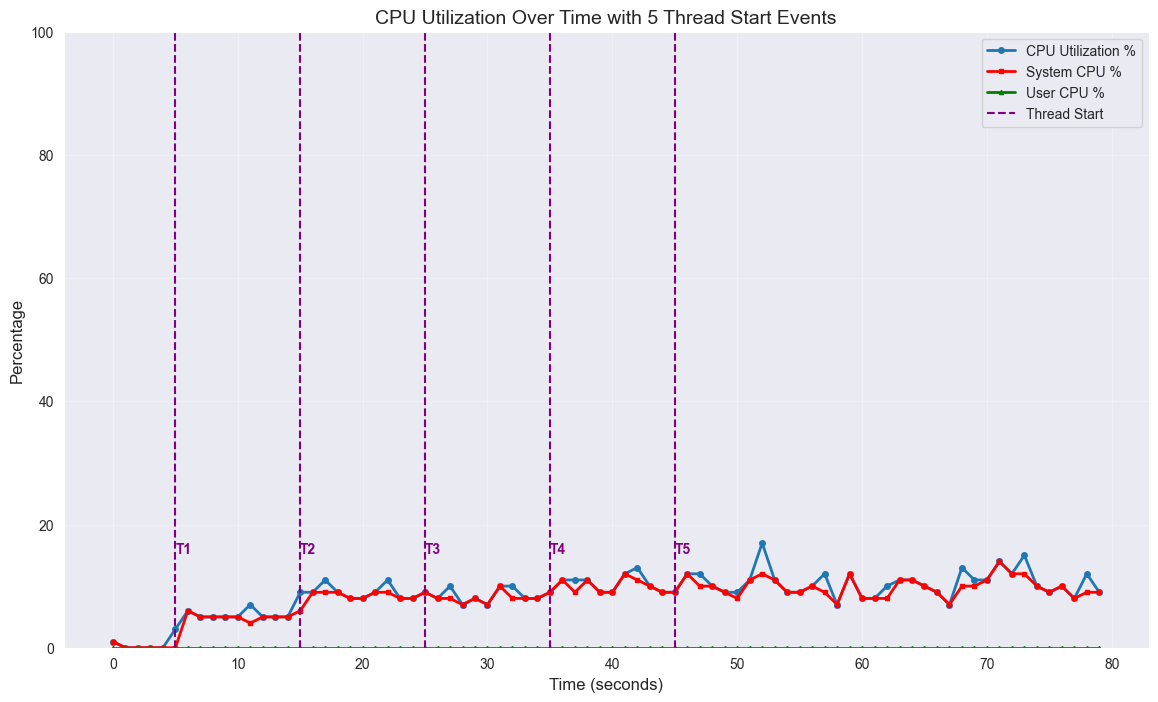

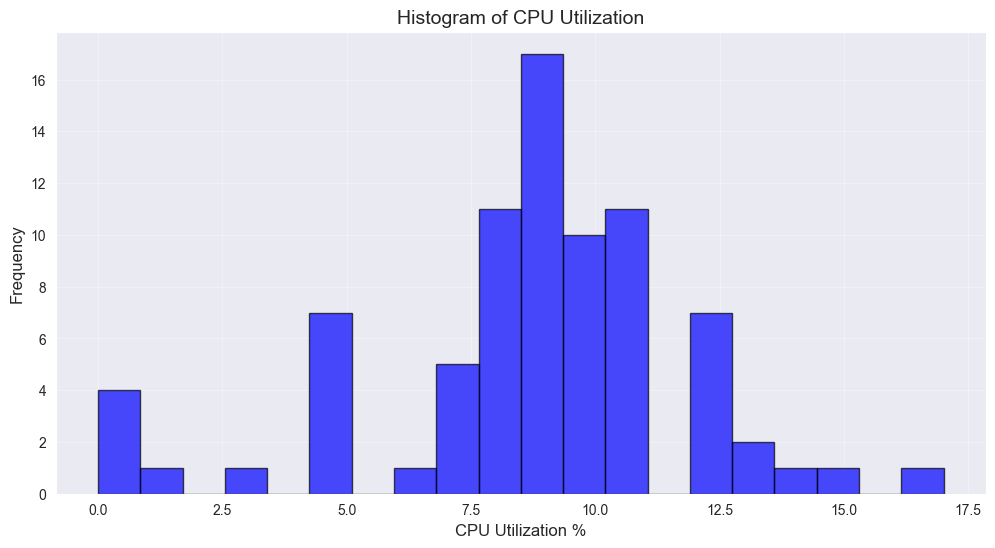

In [6]:
results = visualize_cpu_utilization(df, max_threads=5, output_prefix="vmstat_analysis")
# Print the analysis results
for key, value in results.items():
    print(f"{key}: {value}")